In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import pickle
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import mlflow
import os

In [2]:
def read_data_frame(file_path):
    df=pd.read_parquet(file_path)

    df['duration']=df.lpep_dropoff_datetime-df.lpep_pickup_datetime
    df.duration=df.duration.apply(lambda x:x.total_seconds()/60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)
    return df
    
    

In [3]:
df_train=read_data_frame('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_data_frame('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73908 entries, 0 to 76517
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               73908 non-null  int64         
 1   lpep_pickup_datetime   73908 non-null  datetime64[us]
 2   lpep_dropoff_datetime  73908 non-null  datetime64[us]
 3   store_and_fwd_flag     38175 non-null  object        
 4   RatecodeID             38175 non-null  float64       
 5   PULocationID           73908 non-null  object        
 6   DOLocationID           73908 non-null  object        
 7   passenger_count        38175 non-null  float64       
 8   trip_distance          73908 non-null  float64       
 9   fare_amount            73908 non-null  float64       
 10  extra                  73908 non-null  float64       
 11  mta_tax                73908 non-null  float64       
 12  tip_amount             73908 non-null  float64       
 13  tolls_

In [5]:
'''cat_col=df_train.select_dtypes(include='object')
   num_col=df_train.select_dtypes(exclude='object')'''

"cat_col=df_train.select_dtypes(include='object')\n   num_col=df_train.select_dtypes(exclude='object')"

In [6]:
df_train

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


/tmp/ipykernel_436/55724668.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.duration)


<Axes: xlabel='duration', ylabel='Density'>

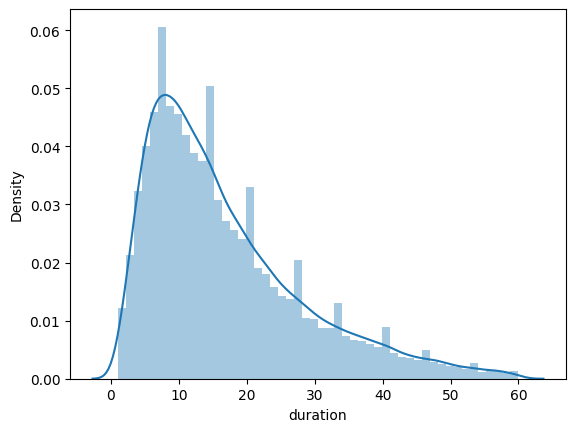

In [7]:
sns.distplot(df_train.duration)

In [8]:
df_train.duration

0         3.933333
1         8.750000
2         5.966667
3         7.083333
7         2.316667
           ...    
76513    38.000000
76514    38.000000
76515    11.000000
76516    27.000000
76517    10.000000
Name: duration, Length: 73908, dtype: float64

In [9]:
df_train.duration.describe()

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
25%          8.050000
50%         14.000000
75%         22.633333
max         60.000000
Name: duration, dtype: float64

In [10]:
df_train.duration.describe(percentiles=[.95,.98,.99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: duration, dtype: float64

In [11]:
cat_cols = ['PULocationID', 'DOLocationID']
num_cols = ['trip_distance']
train_dicts=df_train[cat_cols+num_cols].to_dict(orient='records')
dv=DictVectorizer()
x_train=dv.fit_transform(train_dicts)
target='duration'
y_train=df_train[target].values
lr=LinearRegression()
lr.fit(x_train,y_train)
y_pred=lr.predict(x_train)
mse=mean_squared_error(y_train, y_pred)
rmse=np.sqrt(mse)
rmse

np.float64(9.838799799829626)

/tmp/ipykernel_436/1877227026.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='Prediction')
/tmp/ipykernel_436/1877227026.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='Actual')


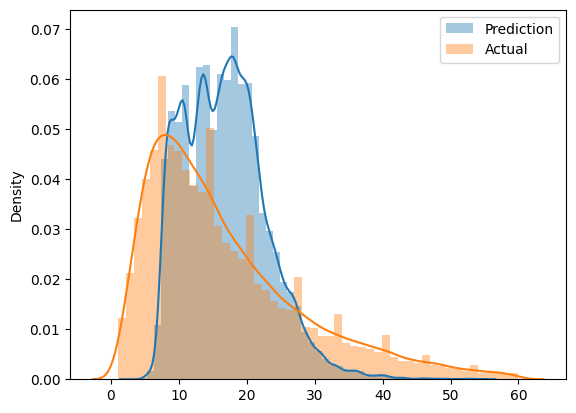

In [12]:
sns.distplot(y_pred, label='Prediction')
sns.distplot(y_train, label='Actual')

plt.legend()

In [13]:
df_train['PU_DO']=df_train['PULocationID']+'_'+df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
cat_col=['PU_DO']
num_col=['trip_distance']
dv=DictVectorizer()
train_dicts=df_train[cat_col+num_col].to_dict(orient='records')
x_train=dv.fit_transform(train_dicts)
val_dicts = df_val[cat_col + num_col].to_dict(orient='records')
x_val = dv.transform(val_dicts)

In [15]:
target='duration'
y_train=df_train[target].values
y_val=df_val[target].values

In [16]:
lr=LinearRegression()
lr.fit(x_train,y_train)
y_pred=lr.predict(x_val)
mse=mean_squared_error(y_val, y_pred)
rmse=np.sqrt(mse)
rmse

np.float64(7.758715210601492)

In [17]:
os.makedirs('./02-experiment-tracking/Models',exist_ok=True)
with open('./02-experiment-tracking/Models/lin_rdge.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
print(os.getcwd())

/app


In [19]:
# set the tracking URI to the MLflow server
mlflow.set_tracking_uri("http://0.0.0.0:5000") # tells mlflow where the tracking server
mlflow.set_experiment("Ebrahim  ") # # creates or selects an experiment to log runs (like training ,metrics,models)

<Experiment: artifact_location='s3://mlflow/1', creation_time=1750097556577, experiment_id='1', last_update_time=1750097556577, lifecycle_stage='active', name='Ebrahim  ', tags={}>

In [20]:
with mlflow.start_run():
    mlflow.sklearn.autolog()  # automatically logs parameters, metrics, and models
    alpha = 0.01
   
    lr = Lasso(alpha=alpha)
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
 

    # Save model
    model_path = './02-experiment-tracking/Models/lin_lasso.bin'
    with open(model_path, 'wb') as f_out:
        pickle.dump((dv, lr), f_out)



2025/06/16 18:17:00 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



🏃 View run clumsy-horse-17 at: http://0.0.0.0:5000/#/experiments/1/runs/d1c9a600f2bf4c8b9174ebd6af8468cf
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/1


In [21]:
lr=Ridge()
lr.fit(x_train,y_train)

y_pred=lr.predict(x_val)
mse=mean_squared_error(y_val, y_pred)
rmse=np.sqrt(mse)
rmse

2025/06/16 18:17:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '493e7b349ba7497c9ca2fb0d7ecaaf45', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run efficient-gull-295 at: http://0.0.0.0:5000/#/experiments/1/runs/493e7b349ba7497c9ca2fb0d7ecaaf45
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/1


np.float64(7.703735147161528)

In [22]:
os.makedirs('Models',exist_ok=True)
with open('Models/rdge.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [23]:
import xgboost as xgb
# use XGBoost's DMatrix :: which is a special data structure optimized for speed and memory
# convert the training and validation data into DMatrix format
train=xgb.DMatrix(x_train, label=y_train) 
valid=xgb.DMatrix(x_val, label=y_val)

In [24]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model','xgboost')
        mlflow.log_params(params)


        booster=xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )

        y_pred=booster.predict(valid)
        mse=mean_squared_error(y_val, y_pred)
        rmse=np.sqrt(mse)
        mlflow.log_metric('rmse', rmse)
    return {'loss':rmse, 'status': STATUS_OK}

In [25]:

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # Range between exp(-3), and exp(0) == [0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lamda': hp.loguniform('reg_lamda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:17:19] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:17:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.31776                           
[1]	validation-rmse:7.05615                           
[2]	validation-rmse:6.67141                           
[3]	validation-rmse:6.54203                           
[4]	validation-rmse:6.48523                           
[5]	validation-rmse:6.45761                           
[6]	validation-rmse:6.44041                           
[7]	validation-rmse:6.42658                           
[8]	validation-rmse:6.41883                           
[9]	validation-rmse:6.41519                           
[10]	validation-rmse:6.41207                          
[11]	validation-rmse:6.40836                          
[12]	validation-rmse:6.40373                          
[13]	validation-rmse:6.40045                          
[14]	validation-rmse:6.39467                          
[15]	validation-rmse:6.39079                          
[16]	validation-rmse:6.38746                          
[17]	validation-rmse:6.38469                          
[18]	valid

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:17:38] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:17:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:9.25844                                                    
[2]	validation-rmse:8.40850                                                    
[3]	validation-rmse:7.83343                                                    
[4]	validation-rmse:7.44440                                                    
[5]	validation-rmse:7.18625                                                    
[6]	validation-rmse:7.01393                                                    
[7]	validation-rmse:6.89709                                                    
[8]	validation-rmse:6.81716                                                    
[9]	validation-rmse:6.76118                                                    
[10]	validation-rmse:6.72196                                                   
[11]	validation-rmse:6.69276                                                   
[12]	validation-rmse:6.67241                                                   
[13]	validation-rmse:6.65628            

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:18:17] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:18:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.00793                                                   
[1]	validation-rmse:8.63842                                                    
[2]	validation-rmse:7.81736                                                    
[3]	validation-rmse:7.33646                                                    
[4]	validation-rmse:7.05774                                                    
[5]	validation-rmse:6.89565                                                    
[6]	validation-rmse:6.79374                                                    
[7]	validation-rmse:6.73020                                                    
[8]	validation-rmse:6.69174                                                    
[9]	validation-rmse:6.66341                                                    
[10]	validation-rmse:6.64208                                                   
[11]	validation-rmse:6.62860                                                   
[12]	validation-rmse:6.61686            

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:18:53] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:18:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.98723                                                    
[2]	validation-rmse:8.13457                                                    
[3]	validation-rmse:7.58731                                                    
[4]	validation-rmse:7.24216                                                    
[5]	validation-rmse:7.02359                                                    
[6]	validation-rmse:6.88343                                                    
[7]	validation-rmse:6.79228                                                    
[8]	validation-rmse:6.73391                                                    
[9]	validation-rmse:6.69271                                                    
[10]	validation-rmse:6.66335                                                   
[11]	validation-rmse:6.64180                                                   
[12]	validation-rmse:6.62542                                                   
[13]	validation-rmse:6.61321            

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:19:35] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:19:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:9.73679                                                    
[2]	validation-rmse:8.92818                                                    
[3]	validation-rmse:8.32534                                                    
[4]	validation-rmse:7.88084                                                    
[5]	validation-rmse:7.55686                                                    
[6]	validation-rmse:7.31967                                                    
[7]	validation-rmse:7.14685                                                    
[8]	validation-rmse:7.01978                                                    
[9]	validation-rmse:6.92689                                                    
[10]	validation-rmse:6.85768                                                   
[11]	validation-rmse:6.80666                                                   
[12]	validation-rmse:6.76688                                                   
[13]	validation-rmse:6.73586            

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:20:23] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:20:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.80273                                                    
[1]	validation-rmse:8.36079                                                    
[2]	validation-rmse:7.53596                                                    
[3]	validation-rmse:7.07111                                                    
[4]	validation-rmse:6.81368                                                    
[5]	validation-rmse:6.66711                                                    
[6]	validation-rmse:6.58215                                                    
[7]	validation-rmse:6.53077                                                    
[8]	validation-rmse:6.49646                                                    
[9]	validation-rmse:6.47488                                                    
[10]	validation-rmse:6.45729                                                   
[11]	validation-rmse:6.44441                                                   
[12]	validation-rmse:6.43379            

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:20:52] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:20:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[6]	validation-rmse:6.69890                                                    
[7]	validation-rmse:6.69482                                                    
[8]	validation-rmse:6.68538                                                    
[9]	validation-rmse:6.67856                                                    
[10]	validation-rmse:6.67278                                                   
[11]	validation-rmse:6.66769                                                   
[12]	validation-rmse:6.66332                                                   
[13]	validation-rmse:6.65874                                                   
[14]	validation-rmse:6.65704                                                   
[15]	validation-rmse:6.65314                                                   
[16]	validation-rmse:6.65164                                                   
[17]	validation-rmse:6.64723                                                   
[18]	validation-rmse:6.64531            

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:21:23] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:21:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[6]	validation-rmse:6.78671                                                    
[7]	validation-rmse:6.78112                                                    
[8]	validation-rmse:6.77134                                                    
[9]	validation-rmse:6.76689                                                    
[10]	validation-rmse:6.76466                                                   
[11]	validation-rmse:6.74741                                                   
[12]	validation-rmse:6.74410                                                   
[13]	validation-rmse:6.73773                                                   
[14]	validation-rmse:6.73569                                                   
[15]	validation-rmse:6.73357                                                   
[16]	validation-rmse:6.73030                                                   
[17]	validation-rmse:6.72701                                                   
[18]	validation-rmse:6.72468            

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:21:54] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:21:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:7.27733                                                    
[3]	validation-rmse:6.99340                                                    
[4]	validation-rmse:6.86325                                                    
[5]	validation-rmse:6.79253                                                    
[6]	validation-rmse:6.75172                                                    
[7]	validation-rmse:6.72800                                                    
[8]	validation-rmse:6.70700                                                    
[9]	validation-rmse:6.69375                                                    
[10]	validation-rmse:6.68790                                                   
[11]	validation-rmse:6.68260                                                   
[12]	validation-rmse:6.68040                                                   
[13]	validation-rmse:6.67729                                                   
[14]	validation-rmse:6.67671            

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:22:20] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:22:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.94044                                                    
[1]	validation-rmse:6.64277                                                    
[2]	validation-rmse:6.61236                                                    
[3]	validation-rmse:6.59709                                                    
[4]	validation-rmse:6.57921                                                    
[5]	validation-rmse:6.57155                                                    
[6]	validation-rmse:6.56714                                                    
[7]	validation-rmse:6.56063                                                    
[8]	validation-rmse:6.55420                                                    
[9]	validation-rmse:6.54463                                                    
[10]	validation-rmse:6.53817                                                   
[11]	validation-rmse:6.52660                                                   
[12]	validation-rmse:6.51907            

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:22:28] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:22:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.39545                                                     
[1]	validation-rmse:7.94475                                                     
[2]	validation-rmse:7.23671                                                     
[3]	validation-rmse:6.89964                                                     
[4]	validation-rmse:6.73471                                                     
[5]	validation-rmse:6.64844                                                     
[6]	validation-rmse:6.60123                                                     
[7]	validation-rmse:6.57192                                                     
[8]	validation-rmse:6.55320                                                     
[9]	validation-rmse:6.53783                                                     
[10]	validation-rmse:6.52963                                                    
[11]	validation-rmse:6.51825                                                    
[12]	validation-rmse:6.51457

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:22:50] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [18:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.09724                                                    
[1]	validation-rmse:10.17948                                                    
[2]	validation-rmse:9.43051                                                     
[3]	validation-rmse:8.82514                                                     
[4]	validation-rmse:8.33959                                                     
[5]	validation-rmse:7.95120                                                     
[6]	validation-rmse:7.64281                                                     
[7]	validation-rmse:7.39740                                                     
[8]	validation-rmse:7.20609                                                     
[9]	validation-rmse:7.05337                                                     
[10]	validation-rmse:6.93483                                                    
[11]	validation-rmse:6.84069                                                    
[12]	validation-rmse:6.76599

KeyboardInterrupt: 

In [ ]:
mlflow.xgboost.autolog(disable=True)


In [ ]:

logged_model = 'runs:/
/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

loaded_model


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [ ]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

xgboost_model

In [ ]:
y_pred = xgboost_model.predict(valid)

y_pred[:10]